<a href="https://colab.research.google.com/github/evolver16/42pro/blob/main/Advanced02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()

Saving climate.csv to climate.csv


In [5]:
# import required libraries
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Clear CUDA cache if using CUDA
if device == 'cuda':
    torch.cuda.empty_cache()
    print("CUDA memory cache cleared.")

Using device: cuda
CUDA memory cache cleared.


In [6]:
# Read the data from the CSV file
df = pd.read_csv("climate.csv")

# Display the first few rows of the dataframe to inspect the data
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wind x,Wind y,max Wind x,max Wind y,Day sin,Day cos,Year sin,Year cos
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


In [7]:
# Generate descriptive statistics of the DataFrame
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wind x,Wind y,max Wind x,max Wind y,Day sin,Day cos,Year sin,Year cos
count,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,7.009100e+04,7.009100e+04,70091.000000,70091.000000
mean,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,-0.627813,-0.407068,-1.018681,-0.733589,-6.083156e-05,-1.428652e-04,0.001614,-0.000672
std,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,1.987440,1.552621,3.095279,2.611890,7.070992e-01,7.071245e-01,0.706813,0.707408
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,-11.305514,-8.274385,-19.641473,-14.883367,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000
25%,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,-1.470727,-1.364699,-2.469210,-2.322709,-7.071068e-01,-7.071068e-01,-0.704504,-0.708115
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,-0.633142,-0.293467,-1.117029,-0.527021,1.321740e-14,-9.732065e-15,0.003316,-0.001122
75%,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,0.299975,0.450077,0.627619,0.822895,7.071068e-01,7.071068e-01,0.708301,0.707423
max,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,8.244699,7.733831,11.913133,14.302308,1.000000e+00,1.000000e+00,1.000000,1.000000


In [8]:
# Convert the 'Date Time' column to datetime format
df['Date Time'] = pd.to_datetime(df['Date Time'],dayfirst=True)
df.describe()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wind x,Wind y,max Wind x,max Wind y,Day sin,Day cos,Year sin,Year cos
count,70091,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,7.009100e+04,7.009100e+04,70091.000000,70091.000000
mean,2012-12-30 06:26:49.413476608,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,-0.627813,-0.407068,-1.018681,-0.733589,-6.083156e-05,-1.428652e-04,0.001614,-0.000672
min,2009-01-01 01:00:00,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,-11.305514,-8.274385,-19.641473,-14.883367,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000
25%,2010-12-31 03:50:00,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,-1.470727,-1.364699,-2.469210,-2.322709,-7.071068e-01,-7.071068e-01,-0.704504,-0.708115
50%,2012-12-30 06:20:00,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,-0.633142,-0.293467,-1.117029,-0.527021,1.321740e-14,-9.732065e-15,0.003316,-0.001122
75%,2014-12-29 18:30:00,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,0.299975,0.450077,0.627619,0.822895,7.071068e-01,7.071068e-01,0.708301,0.707423
max,2016-12-31 23:10:00,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,8.244699,7.733831,11.913133,14.302308,1.000000e+00,1.000000e+00,1.000000,1.000000
std,NaN,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,1.987440,1.552621,3.095279,2.611890,7.070992e-01,7.071245e-01,0.706813,0.707408


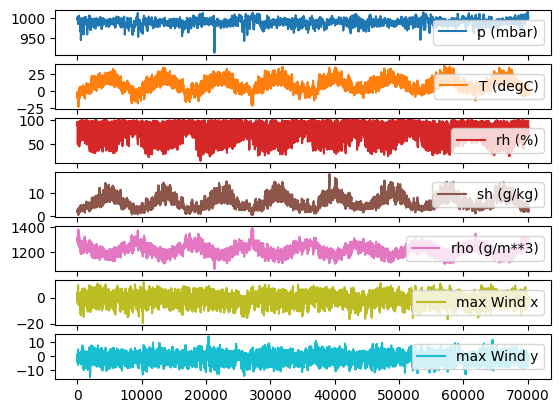

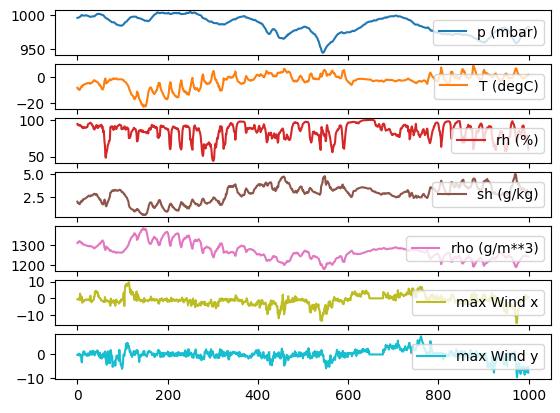

In [9]:
class ClimateDataVisualizer:
    def __init__(self, data_frame):
        self.df = data_frame

    def plot_features(self, columns, num_rows=None):
        """
        Plot the specified columns from the DataFrame.

        Args:
            columns (list): List of column names to plot.
            num_rows (int, optional): Number of rows to limit the plot to. Default is None (use all rows).

        Returns:
            None
        """
        colors = cm.tab10(np.linspace(0, 1, len(columns)))
        plt.figure()
        for i, (col,color) in enumerate(zip(columns,colors)):
            plt.subplot(len(columns), 1, i + 1)
            if num_rows is not None:
                plt.plot(self.df[col][:num_rows],color=color,label=col)
            else:
                plt.plot(self.df[col],color=color,label=col)
            plt.legend(loc='right')

        plt.show()

# Create an instance of the ClimateDataVisualizer class
visualizer = ClimateDataVisualizer(df)

# Define the columns to be plotted
columns_to_plot = ['p (mbar)', 'T (degC)', 'rh (%)', 'sh (g/kg)', 'rho (g/m**3)', 'max Wind x', 'max Wind y']

# Plot the specified columns with the option to limit the number of rows
visualizer.plot_features(columns_to_plot)
visualizer.plot_features(columns_to_plot, num_rows=1000)

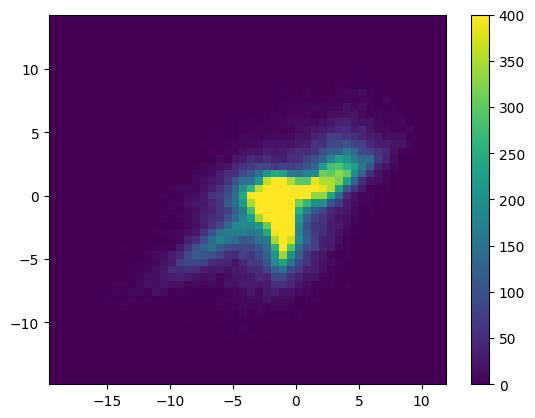

In [10]:
class WindHistogramPlotter:
    def __init__(self, data_frame):
        self.df = data_frame

    def plot_wind_histogram(self):
        """
        Create a 2D histogram plot for two columns of the DataFrame.

        Args:
            x_col (str): The name of the column for the x-axis.
            y_col (str): The name of the column for the y-axis.
            bins (tuple, optional): Number of bins for x and y axes. Default is (50, 50).
            vmax (int, optional): Maximum value for color scale. Default is 400.

        Returns:
            None
        """
        plt.figure()
        plt.hist2d(self.df['max Wind x'], self.df['max Wind y'], bins=(50, 50), vmax=400)
        plt.colorbar()

wind_plotter = WindHistogramPlotter(df)
wind_plotter.plot_wind_histogram()
plt.show()

In [11]:
# Split the data
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=False)

In [12]:
# Normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

/tmp/ipython-input-12-1145706392.py:5: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train_df = (train_df - train_mean) / train_std
/tmp/ipython-input-12-1145706392.py:6: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  val_df = (val_df - train_mean) / train_std


/tmp/ipython-input-13-2801925870.py:18: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  normalized_df = (self.df - self.train_mean) / self.train_std


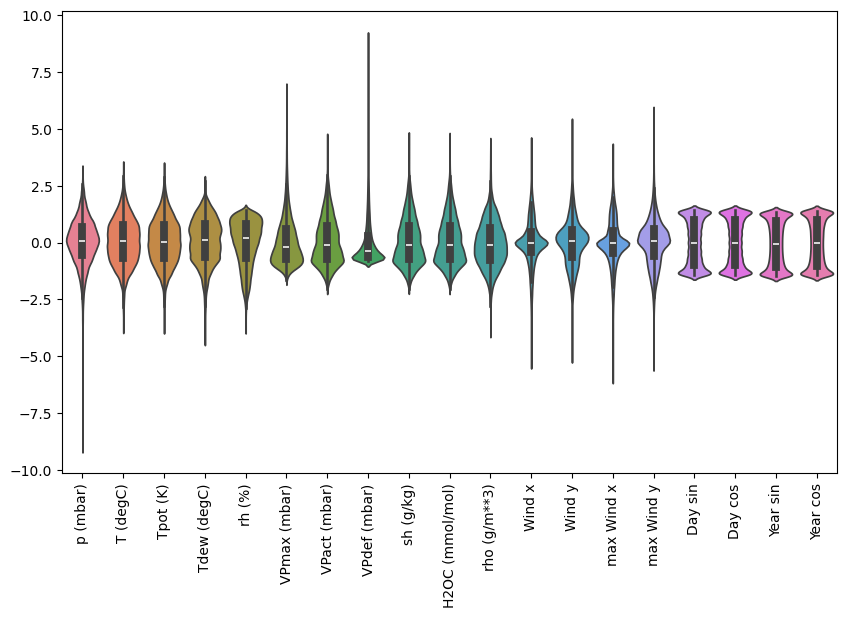

In [13]:
class DataVisualizer:
    def __init__(self, df, train_mean, train_std):
        self.df = df
        self.train_mean = train_mean
        self.train_std = train_std

    def normalize_and_plot(self):
        """
        Normalize the DataFrame and create a violin plot for visualization.

        Args:
            None

        Returns:
            None
        """
        # Normalize the DataFrame
        normalized_df = (self.df - self.train_mean) / self.train_std
        normalized_df = normalized_df.drop(columns=['Date Time'])
        # Create a violin plot
        plt.figure(figsize=(10, 6))
        sns.violinplot(data=normalized_df)
        plt.xticks(rotation=90)

visualizer = DataVisualizer(df, train_mean, train_std)
visualizer.normalize_and_plot()

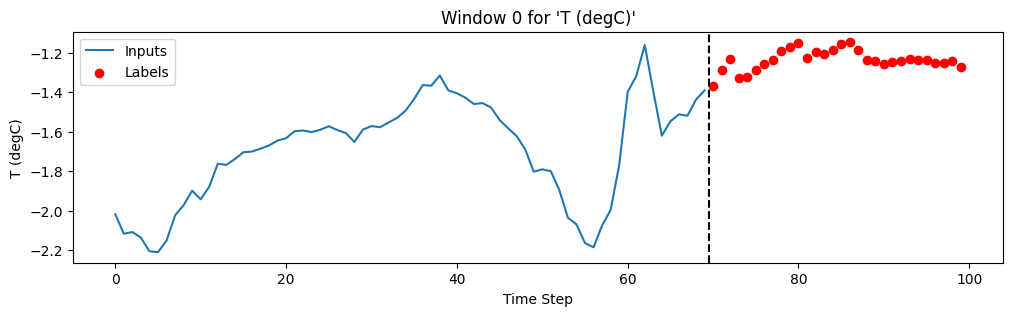

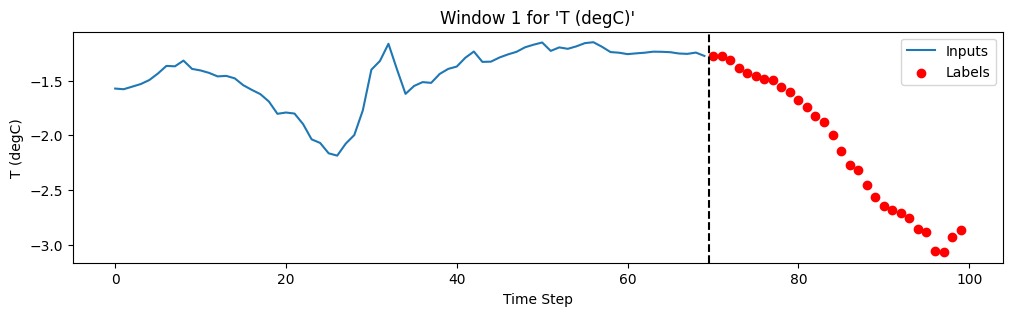

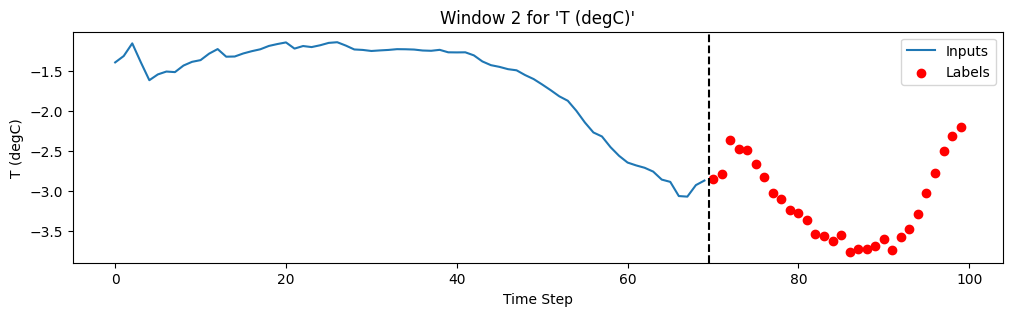

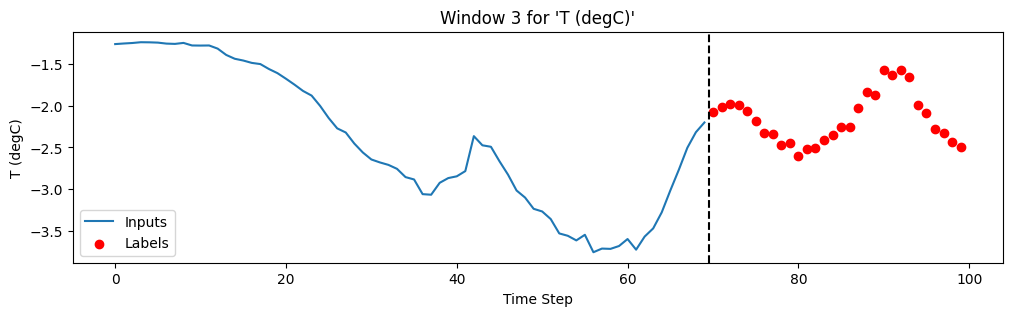

In [14]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift, train_df,val_df, label_columns=None):
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(train_df.columns) if name in label_columns}


        self.total_window_size = input_width + label_width
        self.input_slice = slice(0, input_width)
        self.label_slice = slice(input_width,self.total_window_size)

        self.train = self.makewindow(train_df)
        self.val = self.makewindow(val_df)


    def __repr__(self):
        return (f'WindowGenerator(input_width={self.input_width}, label_width={self.label_width}, '
                f'shift={self.shift}, total_window_size={self.total_window_size}, '
                f'label_columns={self.label_columns})')
    def makewindow(self,df):
        data = df.to_numpy(dtype=np.float32)
        num_samples = int((np.floor(len(data)-self.total_window_size)/self.shift))
        inputs = []
        labels = []

        for i in range(num_samples):
            start = i * self.shift
            end = start + self.total_window_size
            window = data[start:end]

            input_window = window[self.input_slice]
            label_window = window[self.label_slice]

            if self.label_columns is not None:
                label_window = label_window[:, [df.columns.get_loc(col) for col in self.label_columns]]

            inputs.append(input_window)
            labels.append(label_window)
        return np.array(inputs),np.array(labels)

    def get_train(self):
        return self.train

    def get_val(self):
        return self.val

    def plot(self, column_name,model=None, num_plots=4):
        idx = self.column_indices[column_name]
        label_idx = (
            self.label_columns_indices[column_name]
            if self.label_columns is not None
            else idx
        )

        for i in range(min(num_plots, len(self.train[0]))):
            plt.figure(figsize=(12, 3))
            plt.plot(
                range(self.input_width),
                self.train[0][i,:,idx],
                label="Inputs"
            )
            plt.scatter(
                range(self.input_width, self.input_width + self.label_width),
                self.train[1][i,:,idx],
                color='red',
                label="Labels"
            )
            if model is not None:
                input_tensor = torch.tensor(self.train[0][i:i+1], dtype=torch.float32)
                with torch.no_grad():
                  preds = model.predict_future(input_tensor, steps=self.label_width)
                  preds_np = preds.squeeze(0).detach().numpy()[:, label_idx]

                plt.scatter(
                    range(self.input_width, self.input_width + self.label_width),
                    preds_np,
                    color='green',
                    label="Predictions"
                )
            plt.axvline(self.input_width - 0.5, color='black', linestyle='--')
            plt.xlabel("Time Step")
            plt.ylabel(column_name)
            plt.legend()
            plt.title(f"Window {i} for '{column_name}'")
            plt.show()

# Create an instance of WindowGenerator and call the plot method
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=70, label_width=OUT_STEPS, shift=OUT_STEPS, train_df=train_df, val_df=val_df)

multi_window.plot(column_name='T (degC)')

In [26]:

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the last time step
        return out

    def predict_future(self, x, steps):
        """
        Predicts the next `steps` values based on the input sequence `x`.

        Args:
            x (Tensor): Input tensor of shape (batch, seq_len, input_size)
            steps (int): Number of future steps to predict

        Returns:
            Tensor: Predictions of shape (batch, steps, output_size)
        """
        self.eval()  # Inference mode
        preds = []
        input_seq = x

        h = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        for _ in range(steps):
            out, (h, c) = self.lstm(input_seq, (h, c))
            pred = self.fc(out[:, -1, :]).unsqueeze(1)  # (batch, 1, output_size)
            preds.append(pred)
            input_seq = pred  # use prediction as next input

        return torch.cat(preds, dim=1)  # (batch, steps, output_size)

def compile_and_fit(model, window, patience=10, max_epochs=100, learning_rate=5e-4):
    train_x, train_y = window.get_train()
    val_x, val_y = window.get_val()

    # Convert to torch tensors
    train_x = torch.tensor(train_x, dtype=torch.float32)
    train_y = torch.tensor(train_y[:, -1, :], dtype=torch.float32)  # predict last label step
    val_x = torch.tensor(val_x, dtype=torch.float32)
    val_y = torch.tensor(val_y[:, -1, :], dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_x, val_y), batch_size=64)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    wait = 0

    for epoch in range(max_epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                val_loss += criterion(pred, yb).item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Validation loss = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break


In [27]:
# Define a multi-layer LSTM model
input_size = len(multi_window.column_indices)
output_size = len(multi_window.column_indices)

model = SimpleLSTM(input_size=input_size, hidden_size=32, output_size=output_size)
compile_and_fit(model, multi_window)


Epoch 1: Validation loss = 1.1469
Epoch 2: Validation loss = 1.0138
Epoch 3: Validation loss = 0.8873
Epoch 4: Validation loss = 0.8116
Epoch 5: Validation loss = 0.7513
Epoch 6: Validation loss = 0.6813
Epoch 7: Validation loss = 0.6165
Epoch 8: Validation loss = 0.5683
Epoch 9: Validation loss = 0.5309
Epoch 10: Validation loss = 0.5055
Epoch 11: Validation loss = 0.4807
Epoch 12: Validation loss = 0.4688
Epoch 13: Validation loss = 0.4530
Epoch 14: Validation loss = 0.4445
Epoch 15: Validation loss = 0.4330
Epoch 16: Validation loss = 0.4269
Epoch 17: Validation loss = 0.4220
Epoch 18: Validation loss = 0.4222
Epoch 19: Validation loss = 0.4097
Epoch 20: Validation loss = 0.4054
Epoch 21: Validation loss = 0.4043
Epoch 22: Validation loss = 0.4014
Epoch 23: Validation loss = 0.3982
Epoch 24: Validation loss = 0.3963
Epoch 25: Validation loss = 0.3959
Epoch 26: Validation loss = 0.3916
Epoch 27: Validation loss = 0.3980
Epoch 28: Validation loss = 0.3890
Epoch 29: Validation loss = 0

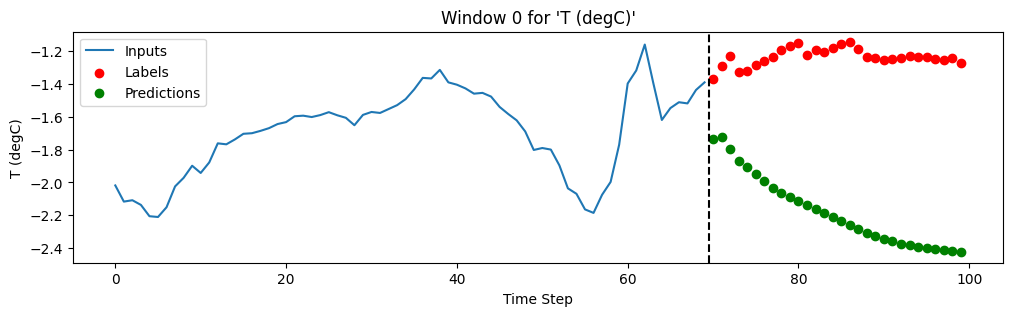

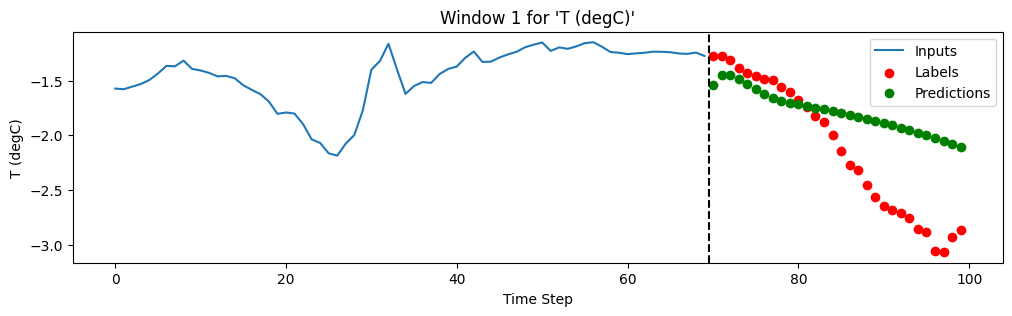

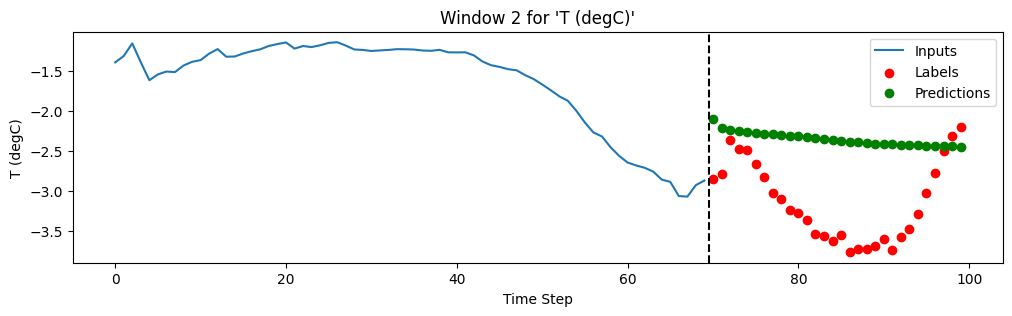

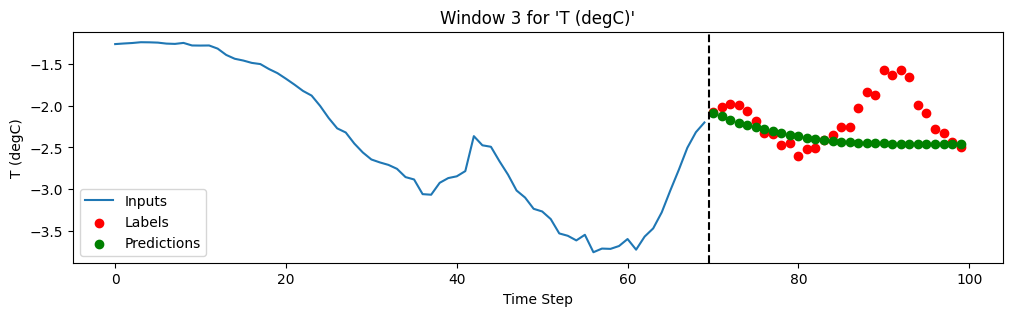

In [28]:
# Plot the model's predictions
multi_window.plot(model=model, column_name='T (degC)')

In [18]:
# Make predictions using the multi-layer LSTM model on the validation data
...

AttributeError: 'WindowGenerator' object has no attribute 'num_features'

In [ ]:
# Denormalize model predictions
...

# Denormalize true test values
...